In [1]:
import os, os.path
import glob
import pickle
import numpy
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util
from gd1_util import R0, V0
import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
from __future__ import print_function

Populating the interactive namespace from numpy and matplotlib


In [2]:
#load the saved pickle file for converting apars to obs coords
with open('/home/nil/Dropbox/streamgap-pepper/pal5_64sampling.pkl','rb') as savefile:
            sdf_smooth= pickle.load(savefile)
            sdf_pepper= pickle.load(savefile)



In [5]:
def convert_dens_apar_to_dens_xi(apars,dens,dens_smooth,mO,poly_deg=3):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens_contrast(xi)-normalized by polynomial fit)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    xi=mxieta[:,0]
    
    #We want to find d(apar)/d(xi) at the apars that's in the output file.
    #Treating those apars and xi as the mid-point of the apar and xi bins, compute the 
    #their edges. Bin widths are not uniform, so a few more lines of code. For the 
    #first and last edge, use the first and last bin width.
    
    apar_edge=[]
    xi_edge=[]

    abw0=apars[1]-apars[0]
    apar_edge.append(apars[0]-(abw0/2.))

    xibw0=xi[1]-xi[0]
    xi_edge.append(xi[0]-(xibw0/2.))


    for ii in range(len(apars)-1):
        abw=apars[ii+1]-apars[ii]
        xibw=xi[ii+1]-xi[ii]
        apar_edge.append(apars[ii]+abw/2.)
        xi_edge.append(xi[ii]+xibw/2.)

    
    abw_last=apars[len(apars)-1]-apars[len(apars)-2]
    apar_edge.append(apars[len(apars)-1]+(abw_last/2.))

    xibw_last=xi[len(xi)-1]-xi[len(xi)-2]
    xi_edge.append(xi[len(xi)-1]+(xibw_last/2.))
    
    #compute d(apar)/d(xi) using finite difference method
    dapar_dxi=(numpy.diff(apar_edge)/numpy.diff(xi_edge))
    
    #Interpolate Jacobian
    ipdapar_dxi=interpolate.InterpolatedUnivariateSpline(xi,dapar_dxi)

    outxi= numpy.arange(0.25,14.35,0.1)
    # Interpolate xi and apar
    ipxi= interpolate.InterpolatedUnivariateSpline(xi,apars)
    
    #dens(xi) = dens(apars)*d(apar)/d(xi)
       
    ipdens_apar= interpolate.InterpolatedUnivariateSpline(apars,dens) #note only dens
    ipdens_smooth_apar= interpolate.InterpolatedUnivariateSpline(apars,dens_smooth)
    
    dens_xi=ipdens_apar(ipxi(outxi))*ipdapar_dxi(outxi)
    dens_smooth_xi=ipdens_smooth_apar(ipxi(outxi))*ipdapar_dxi(outxi)
    
    pp= Polynomial.fit(outxi,dens_xi,deg=poly_deg)
    
    return (outxi,dens_xi,dens_smooth_xi,pp(outxi))
    #return (outxi,dens_xi/pp(outxi))



def convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    outll= numpy.arange(0.25,14.35,0.1)
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(mxieta[:,0],apars)
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outll,ipdens(ipll(outll)))
    

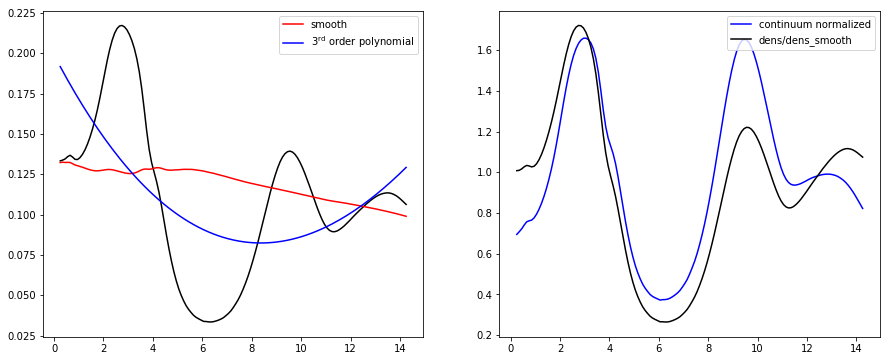

In [6]:
bfilename= '/home/nil/Dropbox/streamgap-pepper/streamdata/pal5_multtime/fromJo/'
dens_filename='pal5_t64sampling_X10_6-9_dens.dat'
omega_filename= dens_filename.replace('dens','omega')

dens_a= np.genfromtxt(bfilename + dens_filename,delimiter=',',max_rows=5002)
omega_a=np.genfromtxt(bfilename + omega_filename,delimiter=',',max_rows=5002)

from random import randint
#sim_ind=randint(2, len(dens_a)-1)
#print sim_ind
sim_ind=25 #20
apars=dens_a[0]
dens_unp=dens_a[1]
omega=omega_a[sim_ind]
dens=dens_a[sim_ind]

#fo=open('apars_dens_simind25.dat','w')
#fo.write('#apars     dens' + '\n')
#for i in range(len(apars)):
#    fo.write(str(apars[i]) + "   " + str(dens[i]) + "\n")
    
#fo.close()

xi,densxi,densxi_smooth,ppdens=convert_dens_apar_to_dens_xi(apars,dens,dens_unp,omega,poly_deg=3)

xi1,dens_con= convert_dens_to_obs(apars,dens,dens_unp,omega)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(xi,densxi,c='k')
plt.plot(xi,densxi_smooth,c='r',label='smooth')


plt.plot(xi,ppdens,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.legend(loc='upper right')
plt.subplot(1,2,2)

plt.plot(xi,densxi/ppdens,c='b',label='continuum normalized')
plt.plot(xi1,dens_con,c='k',label='dens/dens_smooth')
plt.legend(loc='upper right')


plt.show()

# sample apar

In [7]:
from scipy import integrate
#interpolate to get dens(apar), dens is NOT dens_contrast

ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens)

norm=integrate.romberg(ipdens,min(apars),max(apars),divmax=20)

def dens_pdf(a):
    
    return ipdens(a)/norm

def dens_cdf(a):
      
    return integrate.romberg(dens_pdf,min(apars),a,divmax=20)
    

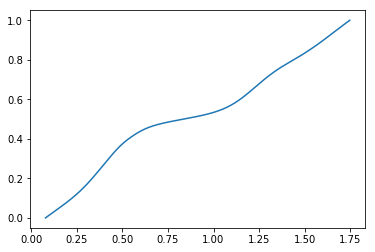

In [8]:
cdf=[dens_cdf(i) for i in apars]

plt.figure()
plt.plot(apars,cdf)
plt.show()

In [19]:
icdf= interpolate.InterpolatedUnivariateSpline(cdf,apars,k=2)
samp_apar = icdf(numpy.random.uniform(size=100000))

print (len(samp_apar))

100000


In [30]:
print (numpy.sum(densxi)*0.1)

1.5519119614


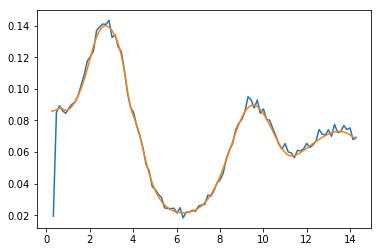

In [32]:
def convert_apar_to_xi(ap):
    """
    
    """
    mT= sdf_pepper.meanTrack(apars,_mO=omega,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    xi=mxieta[:,0]
    ipapar= interpolate.InterpolatedUnivariateSpline(apars,xi)
    return (ipapar(ap))

sample_xi=convert_apar_to_xi(samp_apar)

outxi= numpy.arange(0.25,14.35,0.1)
bw=0.1
#xi_bin_edge=[outxi[0]-(bw/2.) + i*bw for i in range(len(outxi)+1)]



xi_edge=np.linspace(0.25,14.35,100)
midxi=[0.5*(xi_edge[i]+xi_edge[i+1]) for i in range(len(xi_edge)-1)]

count=numpy.histogram(sample_xi,xi_edge,density=True)[0]

plt.figure()
plt.plot(midxi,count)
plt.plot(outxi,densxi/(numpy.sum(densxi)*bw)) #divided by the area
plt.show()

In [38]:
#plot power spectrum 

def read_data(filename):
    data1= numpy.genfromtxt(filename,delimiter=',',max_rows=5002)
    # Search for batches
    batchfilenames= glob.glob(filename.replace('.dat','.*.dat'))
    for bfilename in batchfilenames:
        try:
            datab= numpy.genfromtxt(bfilename,delimiter=',')
        except: continue
        data1= numpy.vstack((data1,datab[2:]))
    return data1
def read_dens(filename,indx=None,rand=False,poly_deg=3):
    densdata= read_data(filename)
    mOfilename= filename.replace('dens','omega')
    mOdata= read_data(mOfilename)
    apars= densdata[0]
    nsim= len(densdata)-2 # first two are apar and smooth
    ll,tdata1= convert_dens_to_obs(apars,densdata[2],densdata[1],
                                   mOdata[2],poly_deg=poly_deg)
    if not indx is None:
        return convert_dens_to_obs(apars,densdata[2+indx],densdata[1],
                                   mOdata[2+indx])
    if rand:
        rindx= int(numpy.floor(numpy.random.uniform()*nsim))
        print (rindx)
        return convert_dens_to_obs(apars,densdata[2+rindx],densdata[1],
                                   mOdata[2+rindx])
    out= numpy.zeros((nsim,len(tdata1)))
    for ii in range(nsim):
        ll, tdata1= convert_dens_to_obs(apars,densdata[2+ii],densdata[1],
                                        mOdata[2+ii])
        out[ii]= tdata1
    return (ll,out)

def median_csd(filename,filename2=None,scatter=False,
              coord1=1,coord2=1,
              err1=None,err2=None,
              poly_deg=3):
    # Compute the median CSD, if filename2 is not None, compute cross
    data1= read_data(filename)
    if filename2 is None:
        data2= data1
    else:
        data2= read_data(filename2)
    if coord1 == 'dens':
        mOfilename= filename.replace('dens','omega')
        mOdata1= read_data(mOfilename)
    if coord2 == 'dens':
        if filename2 is None:
            mOdata2= mOdata1
        else:
            mOfilename2= filename2.replace('dens','omega')
            mOdata2= read_data(mOfilename2)
    apars= data1[0]
    nsim= len(data1)-2 # first two are apar and smooth
    if nsim < 1000:
        print ("WARNING: Using fewer than 1,000 (%i) simulations to compute medians from %s" % (nsim,filename))
    if coord1 == 'dens':
        ll,tdata1= convert_dens_to_obs(apars,data1[2],data1[1],mOdata1[2],poly_deg=poly_deg)
        xi,tdataxi1=convert_dens_apar_to_dens_xi(apars,data1[2],data1[1],mOdata1[2],poly_deg=poly_deg)
    else:
        ll,tdata1= convert_track_to_obs(apars,data1[2],coord1)
    if coord2 == 'dens':
        ll,tdata2= convert_dens_to_obs(apars,data2[2],data2[1],mOdata2[2],poly_deg=poly_deg)
        xi,tdataxi2=convert_dens_apar_to_dens_xi(apars,data2[2],data2[1],mOdata2[2],poly_deg=poly_deg)
    else:
        ll,tdata2= convert_track_to_obs(apars,data2[2],coord2)
    px= signal.csd(tdata1,tdata2,fs=1./(ll[1]-ll[0]),scaling=scaling,nperseg=len(ll))[0]
    ppy= numpy.empty((nsim,len(px)))
    ppy_err= numpy.empty((nsim,len(px)))
    
    ppx= signal.csd(tdataxi1,tdataxi2,fs=1./(xi[1]-xi[0]),scaling=scaling,nperseg=len(xi))[0]
    pppy= numpy.empty((nsim,len(ppx)))
    pppy_err= numpy.empty((nsim,len(ppx)))
    
    for ii in range(nsim):
        # convert
        if coord1 == 'dens':
            ll,tdata1= convert_dens_to_obs(apars,data1[2+ii],data1[1],mOdata1[2+ii],poly_deg=poly_deg)
            xi,tdataxi1=convert_dens_apar_to_dens_xi(apars,data1[2+ii],data1[1],mOdata1[2+ii],poly_deg=poly_deg)
        else:
            ll,tdata1= convert_track_to_obs(apars,data1[2+ii],coord1)
        if numpy.any(data1[2+ii] != data2[2+ii]):
            if coord2 == 'dens':
                ll,tdata2= convert_dens_to_obs(apars,data2[2+ii],data2[1],mOdata2[2+ii],poly_deg=poly_deg)
                xi,tdataxi2=convert_dens_apar_to_dens_xi(apars,data2[2+ii],data2[1],mOdata2[2+ii],poly_deg=poly_deg)
            else:
                ll,tdata2= convert_track_to_obs(apars,data2[2+ii],coord2)
            ppy[ii]= numpy.absolute(signal.csd(tdata1,tdata2,
                                               fs=1./(ll[1]-ll[0]),scaling=scaling,
                                               nperseg=len(ll))[1])
        else:
            ppy[ii]= signal.csd(tdata1,tdata1,
                                fs=1./(ll[1]-ll[0]),scaling=scaling,
                                nperseg=len(ll))[1].real
            
            pppy[ii]= signal.csd(tdataxi1,tdataxi1,
                                fs=1./(xi[1]-xi[0]),scaling=scaling,
                                nperseg=len(xi))[1].real
        # Same for errors
        if not err1 is None:
            tmock1= err1*numpy.random.normal(size=len(ll))
            tmockxi1= err1*numpy.random.normal(size=len(ll))
            if numpy.any(data1[2+ii] != data2[2+ii]):
                tmock2= err2*numpy.random.normal(size=len(ll))
                ppy_err[ii]= numpy.absolute(signal.csd(tmock1,tmock2,
                                                       fs=1./(ll[1]-ll[0]),scaling=scaling,
                                                       nperseg=len(ll))[1])
            else:
                ppy_err[ii]= signal.csd(tmock1,tmock1,
                                        fs=1./(ll[1]-ll[0]),scaling=scaling,
                                        nperseg=len(ll))[1].real
    # Following is the correct scaling in the sense that random noise gives same CSD no matter how long the stream
    if not scatter:
        return (1./px,1./ppx,numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0])),
                numpy.sqrt(numpy.nanmedian(pppy,axis=0)*(xi[-1]-xi[0])),
                numpy.sqrt(numpy.nanmedian(ppy_err,axis=0)*(ll[-1]-ll[0])))
    else:
        out= numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0]))
        outxi= numpy.sqrt(numpy.nanmedian(pppy,axis=0)*(xi[-1]-xi[0]))
        ppy.sort(axis=0)
        pppy.sort(axis=0)
        return (1./px,1./ppx,out,outxi,
                numpy.sqrt(ppy[int(numpy.round(0.25*nsim))]*(ll[-1]-ll[0])),
                numpy.sqrt(ppy[int(numpy.round(0.75*nsim))]*(ll[-1]-ll[0])),
                numpy.sqrt(pppy[int(numpy.round(0.25*nsim))]*(xi[-1]-xi[0])),
                numpy.sqrt(pppy[int(numpy.round(0.75*nsim))]*(xi[-1]-xi[0])),
                numpy.sqrt(numpy.nanmedian(ppy_err,axis=0)*(ll[-1]-ll[0])))


def plot_dens(filename,poly_deg=3,color=sns.color_palette()[0],zorder=1,ls='-',
              fill=False,fill_color='0.65',fill_zorder=0,
              err_color=sns.color_palette()[2],err_zorder=0,
              err=None,scale=1.,add_err=0.):
    px,ppx, py,ppy, py_err= median_csd(filename,coord1='dens',coord2='dens',
                               err1=err,poly_deg=poly_deg)
    py= numpy.sqrt(py**2.+add_err**2.)
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    loglog(ppx,scale*ppy,lw=2.,color='r',zorder=zorder,ls='--')
    if not err is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx,plotpx, dum,dum1, low, high,lowp,highp, dum= median_csd(filename,scatter=True,
                                               coord1='dens',coord2='dens',
                                               poly_deg=poly_deg)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
        fill_between(plotpx,scale*lowp,scale*highp,color='r',zorder=fill_zorder,alpha=0.1)
    return None

def set_ranges_and_labels_dens():
    bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$')
    ylim(0.01,10.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None

/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in divide

/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in divide



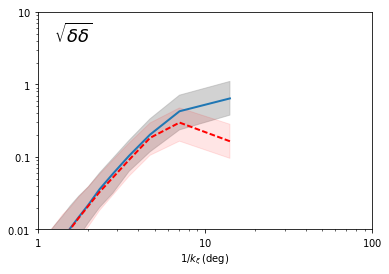

In [40]:
scaling= 'spectrum'
plot_dens(bfilename + dens_filename,fill=True)
set_ranges_and_labels_dens()